In [59]:
import os

import pandas as pd
import numpy as np

import itertools 

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import statsmodels.formula.api as smf


from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import Lasso, Ridge, LinearRegression
import scipy.stats as stats



import folium
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

import scrub_and_explore as se
import model as m

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Obtain Data

Airbnb data for Washington DC (as of 9/22/19): http://insideairbnb.com/about.html


## Question

We would like to know if the price of a listing can be predicted. In determining our original set of variables, we will use mirror the variables used on the Airbnb site.

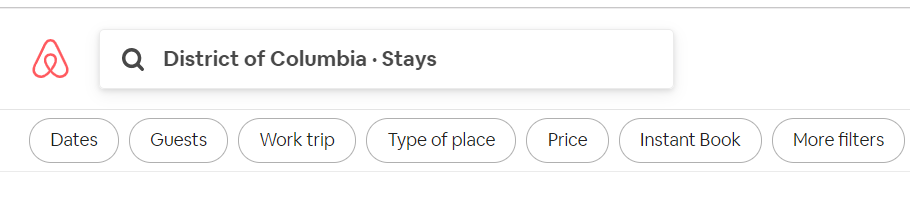

Specifically, we will start with the following variables (written as Airbnb filter: 'variable in dataset'):

- Guests: 'guests_included'
- Work trip: 'is_business_travel_ready'
- Type of place: 'room_type'
- Instant Book: 'instant_bookable'
- Beds: 'beds'
- Bedrooms: 'bedrooms'
- Bathrooms: 'bathrooms'
- Superhost: 'host_is_superhost'
- Amenities: 'amenities'
- Property type: 'property_type'
- Neighborhoods: 'neighbourhood_cleansed'

May want to consider 'bed_type' and 'ratings(ish)' columns later


## Read in Data with Desired Variables

In [60]:
# Read in csv
listings = pd.read_csv('data/listings.csv.gz')

# Filter to list of variables
var_list = ['id', 'price', 'guests_included', 'is_business_travel_ready', 'room_type', 'instant_bookable', 'beds', 'bedrooms', 'bathrooms', 'host_is_superhost', 'property_type', 'neighbourhood_cleansed', 'amenities']
listings = listings.loc[:,var_list]

# Scrub and Explore Data

## Explore Data

In [61]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Head()

In [62]:
listings.head()

,id,price,guests_included,is_business_travel_ready,room_type,instant_bookable,beds,bedrooms,bathrooms,host_is_superhost,property_type,neighbourhood_cleansed,amenities
0,3344,$58.00,1,f,Private room,t,1.0,1.0,1.0,f,Condominium,"Downtown, Chinatown, Penn Quarters, Mount Vern...","{TV,""Cable TV"",Internet,Wifi,""Air conditioning..."
1,3362,$433.00,8,f,Entire home/apt,t,6.0,4.0,3.5,f,Townhouse,"Shaw, Logan Circle","{TV,Internet,Wifi,""Air conditioning"",Kitchen,""..."
2,3662,$65.00,1,f,Private room,f,1.0,1.0,1.0,f,House,Historic Anacostia,"{TV,Internet,Wifi,Kitchen,""Free parking on pre..."
3,3670,$75.00,1,f,Private room,f,1.0,1.0,1.0,f,Townhouse,"Howard University, Le Droit Park, Cardozo/Shaw","{Wifi,""Air conditioning"",""Pets live on this pr..."
4,3686,$55.00,1,f,Private room,f,1.0,1.0,1.0,f,House,Historic Anacostia,"{Internet,Wifi,Kitchen,""Free street parking"",""..."


### Info()

In [63]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9189 entries, 0 to 9188
Data columns (total 13 columns):
id                          9189 non-null int64
price                       9189 non-null object
guests_included             9189 non-null int64
is_business_travel_ready    9189 non-null object
room_type                   9189 non-null object
instant_bookable            9189 non-null object
beds                        9180 non-null float64
bedrooms                    9184 non-null float64
bathrooms                   9178 non-null float64
host_is_superhost           9188 non-null object
property_type               9189 non-null object
neighbourhood_cleansed      9189 non-null object
amenities                   9189 non-null object
dtypes: float64(3), int64(2), object(8)
memory usage: 933.3+ KB


- Few missing values, will deal with later
- Price is an object, so we will convert this

### Explore categorical variables values

In [64]:
# Create list of categorical variables
categorical_vars = list(listings.select_dtypes(include=['object']).columns)

# Apply describe function
se.describe_categorical_variables(listings, categorical_vars)

price has 471 values
$100.00    369
$150.00    319
$75.00     263
$125.00    228
$90.00     218
Name: price, dtype: int64


is_business_travel_ready has 1 values
f    9189
Name: is_business_travel_ready, dtype: int64


room_type has 4 values
Entire home/apt    6567
Private room       2363
Shared room         207
Hotel room           52
Name: room_type, dtype: int64


instant_bookable has 2 values
f    4906
t    4283
Name: instant_bookable, dtype: int64


host_is_superhost has 3 values
f    6198
t    2990
Name: host_is_superhost, dtype: int64


property_type has 23 values
Apartment      4214
House          1918
Townhouse      1421
Condominium     765
Guest suite     504
Name: property_type, dtype: int64


neighbourhood_cleansed has 39 values
Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View    911
Union Station, Stanton Park, Kingman Park                     898
Capitol Hill, Lincoln Park                                    798
Edgewood, Bloomingdale, Truxton Circle, Eckington  

- 'is_business_travel_ready' is 1 value -> drop it since every row has same value
- 'instant_bookable' is categorical dummy -> convert to dummy
- 'host_is_superhost' is categorical dummy -> convert to dummy
- convert 'room_type' to dummy
- convert 'property_type' to dummy
- convert 'neighbourhood_cleansed' to dummy
- convert 'amenities' to dummy

In [65]:
listings_c = listings.copy()

### Clean Price

In [66]:
# Converting price column to numeric
listings_c = se.clean_money_column(listings_c, 'price')

### Drop is_business_travel_ready

In [67]:
listings_c.drop(columns=['is_business_travel_ready'], inplace=True)

### Make dummy variables from the categorical dummy variables

In [68]:
listings_c = se.make_dummy_variable_from_categorical_dummy_variable(listings_c, 'instant_bookable')
listings_c = se.make_dummy_variable_from_categorical_dummy_variable(listings_c, 'host_is_superhost')

### Convert categorical variables to dummy

In [69]:
listings_c = se.get_dummies(listings_c, 'room_type')
listings_c = se.get_dummies(listings_c, 'property_type')
listings_c = se.get_dummies(listings_c, 'neighbourhood_cleansed')

### Convert amenities to dummy

In [70]:
listings_c = se.get_dummies_from_multivalue_column(listings_c, 'amenities', character_list = ["{", "}", "\""], sep=",")

# Pre-Modeling

## Dealing with Null Values

### See null values

In [72]:
se.see_columns_with_nulls(listings_c)

AttributeError: module 'scrub_and_explore' has no attribute 'see_columns_with_nulls'

### Remove null values

In [73]:
listings_c.dropna(inplace=True)

## Correlation

In [74]:
y_var = 'price_clean'

# Make correlation matrix
cor_df = pd.DataFrame(listings_c.corr()[y_var].sort_values(ascending=False)).reset_index()
cor_df.columns = ['variable', 'r']

# See if any variables have 'high' correlation
cor_df[(abs(cor_df['r'])>.7) & (cor_df['variable']!=y_var)]

,variable,r


## Multicollinearity (write a function and do this)

In [48]:
# Get list of columns to test multicollinearity
col_list = list(listings_c.select_dtypes(include=['number']).columns)
col_list.remove('id')
col_list.remove('price_clean')
# Create VIF dataframe
vif = m.see_multicollinearity(listings_c, col_list)

In [49]:
vif

,VIF Score,features
0,3.815003,guests_included
1,6.608152,beds
2,7.477177,bedrooms
3,6.676630,bathrooms
4,2.106169,instant_bookable_EQ_T
5,2.038247,host_is_superhost_EQ_T
6,15.374189,amenities_EQ_ toilet
7,1.812631,amenities_EQ_24-hour check-in
8,2.056248,amenities_EQ_Accessible-height bed
9,12.401847,amenities_EQ_Accessible-height toilet


In [51]:
# Get list of columns with VIF < 10
keep_vars = list(vif.loc[vif['VIF Score']<10, 'features'])
keep_vars
# Keep those columns
vif_keep = m.see_multicollinearity(listings_c, keep_vars)
vif_keep


,VIF Score,features
0,3.755254,guests_included
1,6.587124,beds
2,7.348878,bedrooms
3,6.442259,bathrooms
4,2.035091,instant_bookable_EQ_T
5,2.000939,host_is_superhost_EQ_T
6,1.775283,amenities_EQ_24-hour check-in
7,1.808101,amenities_EQ_Accessible-height bed
8,3.619393,amenities_EQ_Amazon Echo
9,1.806969,amenities_EQ_BBQ grill


In [52]:
# Get list of columns with VIF < 5
keep_vars = list(vif.loc[vif['VIF Score']<5, 'features'])
keep_vars
# Keep those columns
vif_keep = m.see_multicollinearity(listings_c, keep_vars)
vif_keep


,VIF Score,features
0,2.795941,guests_included
1,1.900227,instant_bookable_EQ_T
2,1.870746,host_is_superhost_EQ_T
3,1.703623,amenities_EQ_24-hour check-in
4,1.786008,amenities_EQ_Accessible-height bed
5,1.788364,amenities_EQ_BBQ grill
6,1.386236,amenities_EQ_Baby bath
7,1.292703,amenities_EQ_Baby monitor
8,1.415515,amenities_EQ_Babysitter recommendations
9,1.911355,amenities_EQ_Balcony


## Split into Train and Test (deleting original columns)

In [75]:
y_data = listings_c[['price_clean']]
#x_data = listings_c[list(vif_keep['features'])]
x_data = listings_c.drop(columns=['id', 'price', 'price_clean', 'room_type', 'instant_bookable', 'host_is_superhost', 'property_type', 'neighbourhood_cleansed', 'amenities'])
# cols = list(x_data.columns)+list(y_data)
# train, test = train_test_split(listings[cols], random_state=20, test_size=0.2)
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state=20,test_size=0.2)

In [76]:
x_train.head()

,guests_included,beds,bedrooms,bathrooms,instant_bookable_EQ_T,host_is_superhost_EQ_T,room_type_EQ_Hotel room,room_type_EQ_Private room,room_type_EQ_Shared room,property_type_EQ_Apartment,property_type_EQ_Barn,property_type_EQ_Bed and breakfast,property_type_EQ_Boat,property_type_EQ_Boutique hotel,property_type_EQ_Bungalow,property_type_EQ_Condominium,property_type_EQ_Cottage,property_type_EQ_Dome house,property_type_EQ_Guest suite,property_type_EQ_Guesthouse,property_type_EQ_Hostel,property_type_EQ_Hotel,property_type_EQ_House,property_type_EQ_Loft,property_type_EQ_Other,property_type_EQ_Resort,property_type_EQ_Serviced apartment,property_type_EQ_Tiny house,property_type_EQ_Tipi,property_type_EQ_Townhouse,property_type_EQ_Villa,"neighbourhood_cleansed_EQ_Brookland, Brentwood, Langdon","neighbourhood_cleansed_EQ_Capitol Hill, Lincoln Park","neighbourhood_cleansed_EQ_Capitol View, Marshall Heights, Benning Heights","neighbourhood_cleansed_EQ_Cathedral Heights, McLean Gardens, Glover Park","neighbourhood_cleansed_EQ_Cleveland Park, Woodley Park, Massachusetts Avenue Heights, Woodland-Normanstone Terrace","neighbourhood_cleansed_EQ_Colonial Village, Shepherd Park, North Portal Estates","neighbourhood_cleansed_EQ_Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View","neighbourhood_cleansed_EQ_Congress Heights, Bellevue, Washington Highlands","neighbourhood_cleansed_EQ_Deanwood, Burrville, Grant Park, Lincoln Heights, Fairmont Heights","neighbourhood_cleansed_EQ_Douglas, Shipley Terrace","neighbourhood_cleansed_EQ_Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street","neighbourhood_cleansed_EQ_Dupont Circle, Connecticut Avenue/K Street","neighbourhood_cleansed_EQ_Eastland Gardens, Kenilworth","neighbourhood_cleansed_EQ_Edgewood, Bloomingdale, Truxton Circle, Eckington","neighbourhood_cleansed_EQ_Fairfax Village, Naylor Gardens, Hillcrest, Summit Park","neighbourhood_cleansed_EQ_Friendship Heights, American University Park, Tenleytown","neighbourhood_cleansed_EQ_Georgetown, Burleith/Hillandale","neighbourhood_cleansed_EQ_Hawthorne, Barnaby Woods, Chevy Chase",neighbourhood_cleansed_EQ_Historic Anacostia,"neighbourhood_cleansed_EQ_Howard University, Le Droit Park, Cardozo/Shaw","neighbourhood_cleansed_EQ_Ivy City, Arboretum, Trinidad, Carver Langston","neighbourhood_cleansed_EQ_Kalorama Heights, Adams Morgan, Lanier Heights","neighbourhood_cleansed_EQ_Lamont Riggs, Queens Chapel, Fort Totten, Pleasant Hill","neighbourhood_cleansed_EQ_Mayfair, Hillbrook, Mahaning Heights","neighbourhood_cleansed_EQ_Near Southeast, Navy Yard","neighbourhood_cleansed_EQ_North Cleveland Park, Forest Hills, Van Ness","neighbourhood_cleansed_EQ_North Michigan Park, Michigan Park, University Heights","neighbourhood_cleansed_EQ_River Terrace, Benning, Greenway, Dupont Park","neighbourhood_cleansed_EQ_Shaw, Logan Circle","neighbourhood_cleansed_EQ_Sheridan, Barry Farm, Buena Vista","neighbourhood_cleansed_EQ_Southwest Employment Area, Southwest/Waterfront, Fort McNair, Buzzard Point","neighbourhood_cleansed_EQ_Spring Valley, Palisades, Wesley Heights, Foxhall Crescent, Foxhall Village, Georgetown Reservoir","neighbourhood_cleansed_EQ_Takoma, Brightwood, Manor Park","neighbourhood_cleansed_EQ_Twining, Fairlawn, Randle Highlands, Penn Branch, Fort Davis Park, Fort Dupont","neighbourhood_cleansed_EQ_Union Station, Stanton Park, Kingman Park","neighbourhood_cleansed_EQ_West End, Foggy Bottom, GWU","neighbourhood_cleansed_EQ_Woodland/Fort Stanton, Garfield Heights, Knox Hill","neighbourhood_cleansed_EQ_Woodridge, Fort Lincoln, Gateway",amenities_EQ_ toilet,amenities_EQ_24-hour check-in,amenities_EQ_Accessible-height bed,amenities_EQ_Accessible-height toilet,amenities_EQ_Air conditioning,amenities_EQ_Amazon Echo,amenities_EQ_BBQ grill,amenities_EQ_Baby bath,amenities_EQ_Baby monitor,amenities_EQ_Babysitter recommendations,amenities_EQ_Balcony,amenities_EQ_Bath towel,amenities_EQ_Bathroom essentials,amenities_EQ_Bathtub,amenities_EQ_Ba

## Scaling Variables

In [77]:
col_list = ['guests_included', 'beds', 'bedrooms', 'bathrooms']

x_train_scaled, x_test_scaled = m.standardize_x_data(col_list, x_train, x_test)

In [78]:
x_train.head()

,guests_included,beds,bedrooms,bathrooms,instant_bookable_EQ_T,host_is_superhost_EQ_T,room_type_EQ_Hotel room,room_type_EQ_Private room,room_type_EQ_Shared room,property_type_EQ_Apartment,property_type_EQ_Barn,property_type_EQ_Bed and breakfast,property_type_EQ_Boat,property_type_EQ_Boutique hotel,property_type_EQ_Bungalow,property_type_EQ_Condominium,property_type_EQ_Cottage,property_type_EQ_Dome house,property_type_EQ_Guest suite,property_type_EQ_Guesthouse,property_type_EQ_Hostel,property_type_EQ_Hotel,property_type_EQ_House,property_type_EQ_Loft,property_type_EQ_Other,property_type_EQ_Resort,property_type_EQ_Serviced apartment,property_type_EQ_Tiny house,property_type_EQ_Tipi,property_type_EQ_Townhouse,property_type_EQ_Villa,"neighbourhood_cleansed_EQ_Brookland, Brentwood, Langdon","neighbourhood_cleansed_EQ_Capitol Hill, Lincoln Park","neighbourhood_cleansed_EQ_Capitol View, Marshall Heights, Benning Heights","neighbourhood_cleansed_EQ_Cathedral Heights, McLean Gardens, Glover Park","neighbourhood_cleansed_EQ_Cleveland Park, Woodley Park, Massachusetts Avenue Heights, Woodland-Normanstone Terrace","neighbourhood_cleansed_EQ_Colonial Village, Shepherd Park, North Portal Estates","neighbourhood_cleansed_EQ_Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View","neighbourhood_cleansed_EQ_Congress Heights, Bellevue, Washington Highlands","neighbourhood_cleansed_EQ_Deanwood, Burrville, Grant Park, Lincoln Heights, Fairmont Heights","neighbourhood_cleansed_EQ_Douglas, Shipley Terrace","neighbourhood_cleansed_EQ_Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street","neighbourhood_cleansed_EQ_Dupont Circle, Connecticut Avenue/K Street","neighbourhood_cleansed_EQ_Eastland Gardens, Kenilworth","neighbourhood_cleansed_EQ_Edgewood, Bloomingdale, Truxton Circle, Eckington","neighbourhood_cleansed_EQ_Fairfax Village, Naylor Gardens, Hillcrest, Summit Park","neighbourhood_cleansed_EQ_Friendship Heights, American University Park, Tenleytown","neighbourhood_cleansed_EQ_Georgetown, Burleith/Hillandale","neighbourhood_cleansed_EQ_Hawthorne, Barnaby Woods, Chevy Chase",neighbourhood_cleansed_EQ_Historic Anacostia,"neighbourhood_cleansed_EQ_Howard University, Le Droit Park, Cardozo/Shaw","neighbourhood_cleansed_EQ_Ivy City, Arboretum, Trinidad, Carver Langston","neighbourhood_cleansed_EQ_Kalorama Heights, Adams Morgan, Lanier Heights","neighbourhood_cleansed_EQ_Lamont Riggs, Queens Chapel, Fort Totten, Pleasant Hill","neighbourhood_cleansed_EQ_Mayfair, Hillbrook, Mahaning Heights","neighbourhood_cleansed_EQ_Near Southeast, Navy Yard","neighbourhood_cleansed_EQ_North Cleveland Park, Forest Hills, Van Ness","neighbourhood_cleansed_EQ_North Michigan Park, Michigan Park, University Heights","neighbourhood_cleansed_EQ_River Terrace, Benning, Greenway, Dupont Park","neighbourhood_cleansed_EQ_Shaw, Logan Circle","neighbourhood_cleansed_EQ_Sheridan, Barry Farm, Buena Vista","neighbourhood_cleansed_EQ_Southwest Employment Area, Southwest/Waterfront, Fort McNair, Buzzard Point","neighbourhood_cleansed_EQ_Spring Valley, Palisades, Wesley Heights, Foxhall Crescent, Foxhall Village, Georgetown Reservoir","neighbourhood_cleansed_EQ_Takoma, Brightwood, Manor Park","neighbourhood_cleansed_EQ_Twining, Fairlawn, Randle Highlands, Penn Branch, Fort Davis Park, Fort Dupont","neighbourhood_cleansed_EQ_Union Station, Stanton Park, Kingman Park","neighbourhood_cleansed_EQ_West End, Foggy Bottom, GWU","neighbourhood_cleansed_EQ_Woodland/Fort Stanton, Garfield Heights, Knox Hill","neighbourhood_cleansed_EQ_Woodridge, Fort Lincoln, Gateway",amenities_EQ_ toilet,amenities_EQ_24-hour check-in,amenities_EQ_Accessible-height bed,amenities_EQ_Accessible-height toilet,amenities_EQ_Air conditioning,amenities_EQ_Amazon Echo,amenities_EQ_BBQ grill,amenities_EQ_Baby bath,amenities_EQ_Baby monitor,amenities_EQ_Babysitter recommendations,amenities_EQ_Balcony,amenities_EQ_Bath towel,amenities_EQ_Bathroom essentials,amenities_EQ_Bathtub,amenities_EQ_Ba

In [79]:
y_train.head()

,price_clean
7998,300.0
3578,1700.0
299,150.0
8549,180.0
3575,90.0


# Models

## Linear Regression

### Statsmodel way

In [80]:
lin_sm = m.linear_regression_sm(x_train_scaled, y_train)
lin_table = lin_sm.summary(xname=['intercept']+list(x_train_scaled.columns)).tables[1]
lin_table = pd.DataFrame(lin_table.data)
lin_table.columns = lin_table.iloc[0]
lin_table.drop(0, inplace=True)
lin_table = lin_table.set_index(lin_table.columns[0])
lin_table = lin_table.astype(float)
lin_table['coef_abs'] = abs(lin_table['coef'])
lin_table.loc[lin_table['P>|t|']<0.05,].sort_values(by='coef_abs', ascending=False)
#lin_table

,coef,std err,t,P>|t|,[0.025,0.975],coef_abs
,,,,,,,
"neighbourhood_cleansed_EQ_West End, Foggy Bottom, GWU",223.9295,25.231,8.875,0.000,174.469,273.390,223.9295
"neighbourhood_cleansed_EQ_Georgetown, Burleith/Hillandale",182.9276,24.947,7.333,0.000,134.024,231.831,182.9276
amenities_EQ_Waterfront,175.7646,69.638,2.524,0.012,39.253,312.276,175.7646
room_type_EQ_Shared room,-168.5330,25.344,-6.650,0.000,-218.215,-118.851,168.5330
"neighbourhood_cleansed_EQ_Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street",116.5178,23.016,5.062,0.000,71.400,161.636,116.5178
room_type_EQ_Private room,-99.9900,10.545,-9.482,0.000,-120.662,-79.318,99.9900
"neighbourhood_cleansed_EQ_Capitol Hill, Lincoln Park",98.6898,18.456,5.347,0.000,62.511,134.869,98.6898
"neighbourhood_cleansed_EQ_River Terrace, Benning, Greenway, Dupont Park",95.2163,46.248,2.059,0.040,4.557,185.876,95.2163
"neighbourhood_cleansed_EQ_Shaw, Logan Circle",94.7064,19.555,4.843,0.000,56.372,133.041,94.7064


### Sklearn way

In [81]:
lin_sk = m.linear_regression_sklearn(x_train_scaled, y_train)
lin_sk.score(x_train_scaled, y_train)

0.2749363969557437

In [82]:
# See dataframe of y_test and y_pred
lin_sk_y_df = y_test
lin_sk_y_df['y_pred'] = lin_sk.predict(x_test_scaled)
lin_sk_y_df['error'] = lin_sk_y_df['price_clean'] - lin_sk_y_df['y_pred']
lin_sk_y_df['error_sq'] = lin_sk_y_df['error']**2

In [83]:
sum(lin_sk_y_df['error_sq'])

100414365.66458954

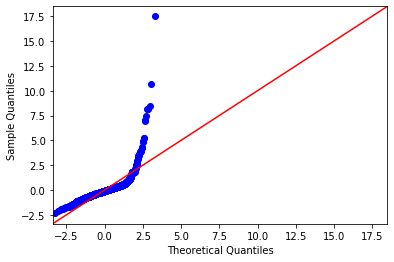

In [84]:
fig = sm.graphics.qqplot(lin_sk_y_df['error'], dist=stats.norm, line='45', fit=True)

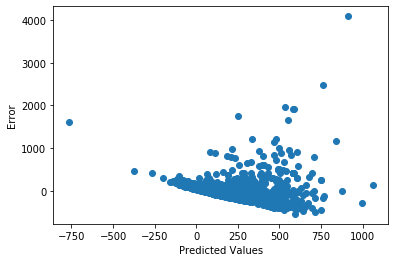

In [85]:
plt.scatter(lin_sk_y_df['y_pred'], lin_sk_y_df['error']);
plt.xlabel('Predicted Values')
plt.ylabel('Error');

## Ridge Regression

### Grid Search

In [86]:
alpha_array = np.array([1000, 100, 10, 1, .1, .01, .001, 0])

In [87]:
grid_search_ridge = m.grid_search(model=Ridge(), alpha_array=alpha_array, x_data=x_train_scaled, y_data=y_train)
best_alpha_ridge = grid_search_ridge.best_estimator_.alpha

### Ridge Regression

In [88]:
ridge = m.ridge_regression(x_train_scaled, y_train, best_alpha_ridge)
print(f"Ridge R^2: {ridge.score(x_train_scaled, y_train)}")
print(f"Ridge # features: {len([x for x in ridge.coef_[0] if abs(x)>0])}")

Ridge R^2: 0.26441946500372815
Ridge # features: 238


In [89]:
len([x for x in ridge.coef_[0] if abs(x)>0])

238

In [90]:
ridge.coef_

array([[-2.32716523e+01, -1.12909361e+00,  9.09293165e+01,
         3.21368366e+01,  2.58312559e+01, -2.25492113e+01,
        -9.87160393e+00, -8.80424192e+01, -9.69263107e+01,
        -4.90181683e+00, -2.60116451e+00,  2.73431978e+00,
        -8.86052203e-02,  5.26275025e+00, -1.96361167e+00,
        -1.68482130e+01, -9.04964193e-01, -3.07559412e+00,
         8.04592686e+00, -1.10680365e+01, -1.47575633e+01,
         6.60366964e-02,  3.52112210e+01,  4.11912375e+00,
        -5.45254449e+00,  1.52429718e+00,  2.44237610e+00,
         1.78323080e+00,  1.04618724e+00,  8.57814602e-01,
        -3.04423319e+00, -1.22602198e+01,  4.25853875e+01,
        -1.12898618e+01,  1.17408664e+01,  9.73562158e+00,
        -2.26947779e+01, -2.14288615e+01, -1.11274830e+01,
        -8.17333982e+00,  1.73868797e+00,  3.98272548e+01,
         1.85549789e+01, -2.02689427e+00,  1.14245284e+00,
        -1.69610072e+01, -2.19721878e+01,  8.67677104e+01,
        -1.09538250e+00, -2.65566124e+01,  1.23136792e+0

In [91]:
ridge_y_df = y_test
ridge_y_df['y_pred'] = ridge.predict(x_test_scaled)
ridge_y_df['error'] = ridge_y_df['price_clean'] - ridge_y_df['y_pred']
ridge_y_df['error_sq'] = ridge_y_df['error']**2

In [92]:
sum(ridge_y_df['error_sq'])

96461728.8675597

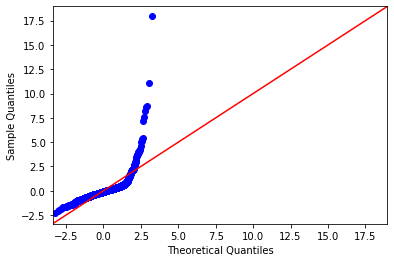

In [93]:
fig = sm.graphics.qqplot(ridge_y_df['error'], dist=stats.norm, line='45', fit=True)


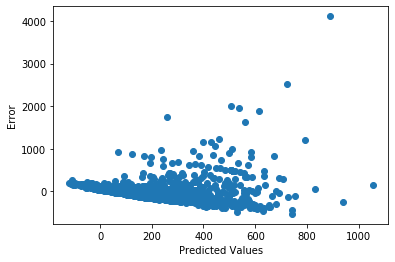

In [94]:
plt.scatter(ridge_y_df['y_pred'], ridge_y_df['error']);
plt.xlabel('Predicted Values')
plt.ylabel('Error');

## Lasso Regression

### Grid Search

In [95]:
grid_search_lasso = m.grid_search(model=Lasso(), alpha_array=alpha_array, x_data=x_train_scaled, y_data=y_train)
best_alpha_lasso = grid_search_lasso.best_estimator_.alpha

### Lasso Regression

In [96]:
lasso = m.lasso_regression(x_train_scaled, y_train, best_alpha_lasso)
lasso.score(x_train_scaled, y_train)

0.2532599319788065

In [97]:
lasso_y_df = y_test
lasso_y_df['y_pred'] = lasso.predict(x_test_scaled)
lasso_y_df['error'] = lasso_y_df['price_clean'] - lasso_y_df['y_pred']
lasso_y_df['error_sq'] = lasso_y_df['error']**2

In [98]:
print(f"Lasso R^2: {lasso.score(x_train_scaled, y_train)}")
print(f"Ridge # features: {len([x for x in lasso.coef_ if abs(x)>0])}")

Lasso R^2: 0.2532599319788065
Ridge # features: 60


In [99]:
sum(lasso_y_df['error_sq'])

97639772.2322518

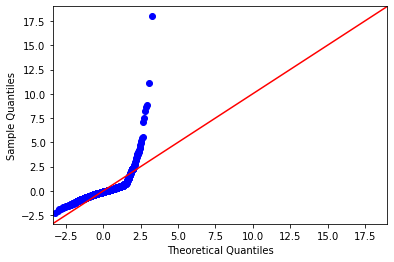

In [100]:
fig = sm.graphics.qqplot(ridge_y_df['error'], dist=stats.norm, line='45', fit=True)

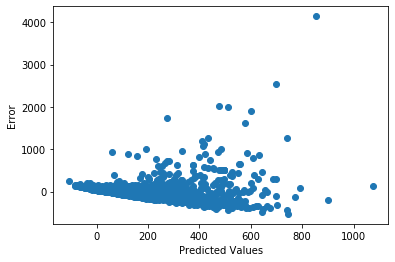

In [101]:
plt.scatter(lasso_y_df['y_pred'], lasso_y_df['error']);
plt.xlabel('Predicted Values')
plt.ylabel('Error');

# Linear Regression Models

## Initial Model

In [102]:
x_data.head()

,guests_included,beds,bedrooms,bathrooms,instant_bookable_EQ_T,host_is_superhost_EQ_T,room_type_EQ_Hotel room,room_type_EQ_Private room,room_type_EQ_Shared room,property_type_EQ_Apartment,property_type_EQ_Barn,property_type_EQ_Bed and breakfast,property_type_EQ_Boat,property_type_EQ_Boutique hotel,property_type_EQ_Bungalow,property_type_EQ_Condominium,property_type_EQ_Cottage,property_type_EQ_Dome house,property_type_EQ_Guest suite,property_type_EQ_Guesthouse,property_type_EQ_Hostel,property_type_EQ_Hotel,property_type_EQ_House,property_type_EQ_Loft,property_type_EQ_Other,property_type_EQ_Resort,property_type_EQ_Serviced apartment,property_type_EQ_Tiny house,property_type_EQ_Tipi,property_type_EQ_Townhouse,property_type_EQ_Villa,"neighbourhood_cleansed_EQ_Brookland, Brentwood, Langdon","neighbourhood_cleansed_EQ_Capitol Hill, Lincoln Park","neighbourhood_cleansed_EQ_Capitol View, Marshall Heights, Benning Heights","neighbourhood_cleansed_EQ_Cathedral Heights, McLean Gardens, Glover Park","neighbourhood_cleansed_EQ_Cleveland Park, Woodley Park, Massachusetts Avenue Heights, Woodland-Normanstone Terrace","neighbourhood_cleansed_EQ_Colonial Village, Shepherd Park, North Portal Estates","neighbourhood_cleansed_EQ_Columbia Heights, Mt. Pleasant, Pleasant Plains, Park View","neighbourhood_cleansed_EQ_Congress Heights, Bellevue, Washington Highlands","neighbourhood_cleansed_EQ_Deanwood, Burrville, Grant Park, Lincoln Heights, Fairmont Heights","neighbourhood_cleansed_EQ_Douglas, Shipley Terrace","neighbourhood_cleansed_EQ_Downtown, Chinatown, Penn Quarters, Mount Vernon Square, North Capitol Street","neighbourhood_cleansed_EQ_Dupont Circle, Connecticut Avenue/K Street","neighbourhood_cleansed_EQ_Eastland Gardens, Kenilworth","neighbourhood_cleansed_EQ_Edgewood, Bloomingdale, Truxton Circle, Eckington","neighbourhood_cleansed_EQ_Fairfax Village, Naylor Gardens, Hillcrest, Summit Park","neighbourhood_cleansed_EQ_Friendship Heights, American University Park, Tenleytown","neighbourhood_cleansed_EQ_Georgetown, Burleith/Hillandale","neighbourhood_cleansed_EQ_Hawthorne, Barnaby Woods, Chevy Chase",neighbourhood_cleansed_EQ_Historic Anacostia,"neighbourhood_cleansed_EQ_Howard University, Le Droit Park, Cardozo/Shaw","neighbourhood_cleansed_EQ_Ivy City, Arboretum, Trinidad, Carver Langston","neighbourhood_cleansed_EQ_Kalorama Heights, Adams Morgan, Lanier Heights","neighbourhood_cleansed_EQ_Lamont Riggs, Queens Chapel, Fort Totten, Pleasant Hill","neighbourhood_cleansed_EQ_Mayfair, Hillbrook, Mahaning Heights","neighbourhood_cleansed_EQ_Near Southeast, Navy Yard","neighbourhood_cleansed_EQ_North Cleveland Park, Forest Hills, Van Ness","neighbourhood_cleansed_EQ_North Michigan Park, Michigan Park, University Heights","neighbourhood_cleansed_EQ_River Terrace, Benning, Greenway, Dupont Park","neighbourhood_cleansed_EQ_Shaw, Logan Circle","neighbourhood_cleansed_EQ_Sheridan, Barry Farm, Buena Vista","neighbourhood_cleansed_EQ_Southwest Employment Area, Southwest/Waterfront, Fort McNair, Buzzard Point","neighbourhood_cleansed_EQ_Spring Valley, Palisades, Wesley Heights, Foxhall Crescent, Foxhall Village, Georgetown Reservoir","neighbourhood_cleansed_EQ_Takoma, Brightwood, Manor Park","neighbourhood_cleansed_EQ_Twining, Fairlawn, Randle Highlands, Penn Branch, Fort Davis Park, Fort Dupont","neighbourhood_cleansed_EQ_Union Station, Stanton Park, Kingman Park","neighbourhood_cleansed_EQ_West End, Foggy Bottom, GWU","neighbourhood_cleansed_EQ_Woodland/Fort Stanton, Garfield Heights, Knox Hill","neighbourhood_cleansed_EQ_Woodridge, Fort Lincoln, Gateway",amenities_EQ_ toilet,amenities_EQ_24-hour check-in,amenities_EQ_Accessible-height bed,amenities_EQ_Accessible-height toilet,amenities_EQ_Air conditioning,amenities_EQ_Amazon Echo,amenities_EQ_BBQ grill,amenities_EQ_Baby bath,amenities_EQ_Baby monitor,amenities_EQ_Babysitter recommendations,amenities_EQ_Balcony,amenities_EQ_Bath towel,amenities_EQ_Bathroom essentials,amenities_EQ_Bathtub,amenities_EQ_Ba

In [103]:
# Get train and test data
y_data = listings_c[['price_clean']]
x_data = listings_c.drop(columns=['id', 'price', 'price_clean', 'room_type', 'instant_bookable', 'host_is_superhost', 'property_type', 'neighbourhood_cleansed', 'amenities'])
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state=20,test_size=0.2)

# Scale x data
x_train_scaled, x_test_scaled = m.standardize_x_data(['guests_included', 'beds', 'bedrooms', 'bathrooms'], x_train, x_test)
model = m.linear_regression_sm(x_train_scaled, y_train)
print(f"R-Squared: {model.rsquared}")
# Run model and create table of output
model_table = model.summary(xname=['intercept']+list(x_train_scaled.columns)).tables[1]
model_table = pd.DataFrame(model_table.data)
model_table.columns = model_table.iloc[0]
model_table.drop(0, inplace=True)
model_table = model_table.set_index(model_table.columns[0])
model_table = model_table.astype(float)
model_table['coef_abs'] = abs(model_table['coef'])
model_table.reset_index(inplace=True)
model_table.rename(columns={'':'variable'}, inplace=True)
print(f"{len(model_table)-1} features")
print(f"{len(model_table.loc[model_table['P>|t|']<0.05])-1} significant features")

R-Squared: 0.2749363969557437
240 features
47 significant features


In [104]:
model_table.sort_values(by='coef_abs', ascending=False)

,variable,coef,std err,t,P>|t|,[0.025,0.975],coef_abs
222,amenities_EQ_Touchless faucets,-6.218233e+02,9.387060e+02,-0.662,0.508,-2.461967e+03,1.218321e+03,6.218233e+02
173,amenities_EQ_Mudroom,5.829924e+02,1.515529e+03,0.385,0.700,-2.387896e+03,3.553881e+03,5.829924e+02
238,amenities_EQ_Wine cooler,5.001751e+02,6.702650e+02,0.746,0.456,-8.137430e+02,1.814094e+03,5.001751e+02
193,amenities_EQ_Printer,-4.871723e+02,1.382987e+03,-0.352,0.725,-3.198238e+03,2.223894e+03,4.871723e+02
152,amenities_EQ_High-resolution computer monitor,4.310844e+02,8.059940e+02,0.535,0.593,-1.148904e+03,2.011073e+03,4.310844e+02
18,property_type_EQ_Dome house,-3.805579e+02,3.222660e+02,-1.181,0.238,-1.012296e+03,2.511800e+02,3.805579e+02
213,amenities_EQ_Sound system,-3.500328e+02,6.226960e+02,-0.562,0.574,-1.570702e+03,8.706370e+02,3.500328e+02
224,amenities_EQ_Warming drawer,-3.223803e+02,9.250790e+02,-0.348,0.727,-2.135812e+03,1.491051e+03,3.223803e+02
0,intercept,3.116851e+02,1.663770e+02,1.873,0.061,-1.446400e+01,6.378340e+02,3.116851e+02
215,amenities_EQ_Standing valet,2.880188e+02,9.205870e+02,0.313,0.754,-1.516606e+03,2.092644e+03,2.880188e+02


## Initial Model Refined

In [106]:
sig_var_list = list(model_table.loc[model_table['P>|t|']<.05, 'variable'])
x_train_scaled_refined = x_train_scaled.loc[:, sig_var_list]

model2 = m.linear_regression_sm(x_train_scaled_refined, y_train)
print(f"R-Squared: {model2.rsquared}")
# Run model and create table of output
model_table2 = model2.summary(xname=['intercept']+list(x_train_scaled_refined.columns)).tables[1]
model_table2 = pd.DataFrame(model_table2.data)
model_table2.columns = model_table2.iloc[0]
model_table2.drop(0, inplace=True)
model_table2 = model_table2.set_index(model_table2.columns[0])
model_table2 = model_table2.astype(float)
model_table2['coef_abs'] = abs(model_table2['coef'])
model_table2.reset_index(inplace=True)
model_table2.rename(columns={'':'variable'}, inplace=True)
print(f"{len(model_table2)-1} features")

print(f"{len(model_table2.loc[model_table2['P>|t|']<0.05])-1} significant features")

R-Squared: 0.2519273311327772
48 features
44 significant features


In [107]:
model_table2
joey = [1, 2, 1, 2, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,1,0, 0, 0, 0,1, 0, 0,1, 0,0,0]

In [108]:
model2.predict(joey)

ValueError: shapes (1,32) and (49,) not aligned: 32 (dim 1) != 49 (dim 0)

In [109]:
model_table2.sort_values(by='coef_abs', ascending=False)

,variable,coef,std err,t,P>|t|,[0.025,0.975],coef_abs
0,intercept,228.7750,20.404,11.212,0.000,188.776,268.774,228.7750
21,"neighbourhood_cleansed_EQ_West End, Foggy Bott...",214.6543,20.038,10.713,0.000,175.375,253.934,214.6543
7,room_type_EQ_Shared room,-163.8197,23.425,-6.993,0.000,-209.739,-117.901,163.8197
14,"neighbourhood_cleansed_EQ_Georgetown, Burleith...",162.1363,20.250,8.007,0.000,122.440,201.833,162.1363
46,amenities_EQ_Waterfront,127.4113,62.392,2.042,0.041,5.105,249.717,127.4113
11,"neighbourhood_cleansed_EQ_Downtown, Chinatown,...",97.4343,17.675,5.513,0.000,62.787,132.082,97.4343
2,bedrooms,94.3789,4.422,21.345,0.000,85.711,103.046,94.3789
17,"neighbourhood_cleansed_EQ_River Terrace, Benni...",87.6332,43.830,1.999,0.046,1.714,173.552,87.6332
29,amenities_EQ_Gym,86.9050,12.319,7.054,0.000,62.756,111.054,86.9050
6,room_type_EQ_Private room,-86.5838,9.013,-9.606,0.000,-104.252,-68.915,86.5838


## Run model on test data

### Remove variables from test

In [110]:
x_test_scaled_refined = x_test_scaled.loc[:, sig_var_list]

### Create y prediction column

In [111]:
x_test_values = x_test_scaled_refined.values
x_test_values = sm.add_constant(x_test_values)
y_pred = model2.predict(x_test_values)

### Add columns to a dataframe

In [112]:
y_test['y_pred'] = y_pred
y_test['error'] = y_test['price_clean']-y_test['y_pred']
y_test['error_sq'] = y_test['error']**2

In [113]:
y_test.head()

,price_clean,y_pred,error,error_sq
5528,150.0,242.851791,-92.851791,8621.455021
8895,160.0,296.862759,-136.862759,18731.414868
8920,132.0,336.982545,-204.982545,42017.843614
3477,1500.0,514.300450,985.699550,971603.603296
4181,415.0,402.116915,12.883085,165.973885


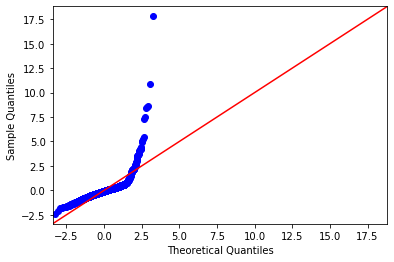

In [114]:
fig = sm.graphics.qqplot(y_test['error'], dist=stats.norm, line='45', fit=True)

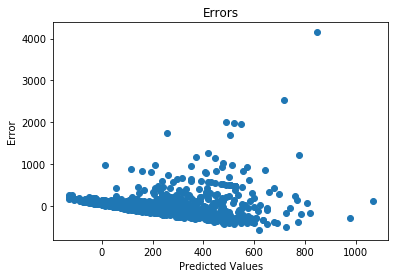

In [115]:
plt.scatter(y_test['y_pred'], y_test['error']);
plt.xlabel('Predicted Values')
plt.ylabel('Error')
plt.title('Errors');

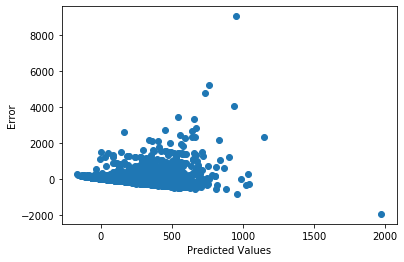

In [116]:
y_train2 = y_train.copy()
y_train2['y_pred'] = model2.predict()
y_train2['error'] = y_train2['price_clean']-y_train2['y_pred']
y_train2['error_sq'] = y_train2['error']**2

plt.scatter(y_train2['y_pred'], y_train2['error']);
plt.xlabel('Predicted Values')
plt.ylabel('Error');

## Maps

In [117]:
import map_building

### 1. Number of Airbnbs in Each Neighborhood

In [145]:
count_of_listings_df = map_building.build_map_df(listings_c, 'price', 'count')

In [146]:
map_building.build_map(count_of_listings_df, 'Count of Listings')

### 2. Average Price of Airbnbs in Each Neighborhood

In [134]:
avg_price_df = map_building.build_map_df(listings_c, 'price_clean', 'mean')

In [147]:
map_building.build_map(avg_price_df, 'Average Price of Listings')

### 3. Count of Waterfront Properties

In [139]:
waterfront_df = map_building.build_map_df(listings_c, 'amenities_EQ_Waterfront', 'mean')

In [140]:
map_building.build_map(waterfront_df, 'Count of Waterfront Properties')

### Average Number of Bedrooms

In [141]:
avg_bedrooms_df = map_building.build_map_df(listings_c, 'beds', 'mean')

In [144]:
map_building.build_map(avg_bedrooms_df, 'Average Bedrooms')